### Zadanie: metryki
Dla nauczonego modelu policz metryki wspomniane w poznanym module o klasyfikacji na zbiorze testowym oraz policz macierz omyłek.

Wynik prześlij Mentorowi jako Jupyter Notebook umieszczony w Twoim GitHubie.

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], 
                names=['Spam', 'Text'], skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

### Usuwanie znaków interpunkcyjnych

In [3]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

### Tokenizacja

In [4]:
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))


In [5]:
stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))


### Lematyzacja

In [6]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

In [289]:
from sklearn.model_selection import GridSearchCV
Tfidf = TfidfVectorizer()
parameters = {
        'min_df': [0.001, 0.002, 0.003],
        'max_df': [0.3, 0.4, 0.5],
        'use_idf':[True, False]
        }
gridsearch = GridSearchCV(Tfidf,
                             parameters,
                             scoring='f1_macro')
gridsearch.fit(spam_dataset)
print('\nBest hyperparameter:', gridsearch.best_params_)
Tfdif_grid = gridsearch.best_estimator_


Best hyperparameter: {'max_df': 0.3, 'min_df': 0.001, 'use_idf': True}


In [7]:
tfidf = TfidfVectorizer(max_df = 0.3, min_df = 0.001, use_idf = True)
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
print(X.shape)
y = spam_dataset['Spam']
print(y.shape)

(5572, 1364)
(5572,)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=42, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], 
                                                                X_test.shape[0]))

Treningowe obserwacje: 4457
Testowe obserwacje: 1115


In [282]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
parameters = {
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [1, 3, 5],
        'n_estimators':[100, 500, 1000]
        }
gridsearch = GridSearchCV(clf,
                        parameters,
                        scoring='f1_macro'
                        )
gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', gridsearch.best_params_)
clf_grid = gridsearch.best_estimator_


Best hyperparameter: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 100}


In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=1, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9506726457399103

In [10]:
print(f'model score on training data: {clf.score(X_train, y_train)}')
print(f'model score on testing data: {clf.score(X_test, y_test)}')

model score on training data: 0.9618577518510208
model score on testing data: 0.9506726457399103


In [19]:
predictions_clf = clf.predict(X_test)
predictions_train = clf.predict(X_train)

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
from sklearn.metrics import classification_report

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       1.00      0.63      0.77       149

    accuracy                           0.95      1115
   macro avg       0.97      0.82      0.87      1115
weighted avg       0.95      0.95      0.95      1115



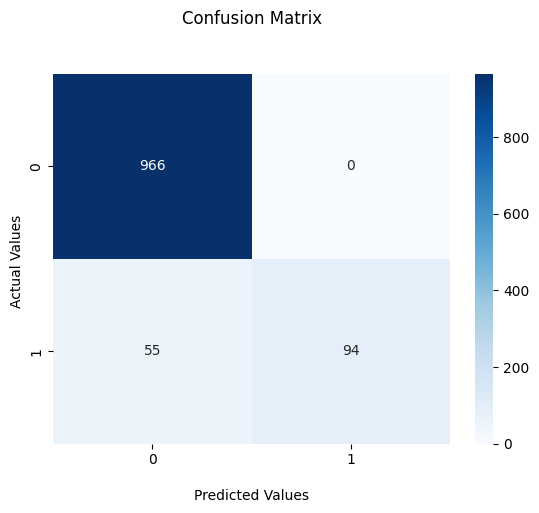

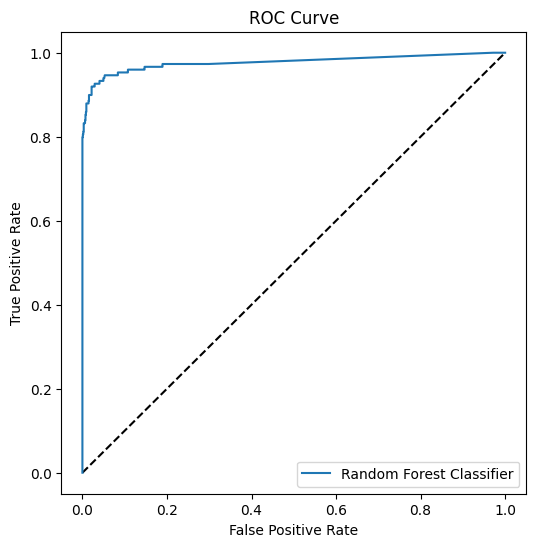

C:\Users\magda\AppData\Local\Temp\ipykernel_13200\2222207455.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Random Forest Classifier,0.773663,0.977049


In [17]:
calculate_metrics(clf, 'Random Forest Classifier', X_test, y_test)